## DSA4262 Assignment 2

## Remark
Due to the inherent randomness in model training, rerunning the experiments may produce slightly different results, which could cause discrepancies between the text descriptions and the numerical outputs. All experiments were genuinely conducted. 

Additionally, all code was run on Kaggle to leverage its free GPU. If the grader runs the code in a different environment, some errors may occur due to package or version differences, not because of issues with the code itself. I kindly ask for the professor’s and tutor’s understanding.

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [4]:
!cp -r /kaggle/input/datasets/junjietian/dsa4262-assignment2-data/Assignment_2/dreaddit /kaggle/working/

%cd /kaggle/working
!ls /kaggle/working
!ls /kaggle/working/dreaddit

/kaggle/working
dreaddit
dreaddit-test.csv  dreaddit-train.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## 1. Introduction

Stress and mental health concerns have become increasingly prominent, especially in online communities where individuals often seek advice and support. Automatically detecting stress from textual data can help clinicians, social workers, and support platforms identify individuals at risk and provide timely interventions.

In this project, we explore a variety of machine learning approaches to predict stress from text data collected from multiple subreddits. The workflow begins with exploratory data analysis to understand patterns and distributions, followed by text preprocessing to standardize and clean the data. We then establish baseline models, including Logistic Regression and Random Forest, and experiment with FastText as a shallow text representation model. Finally, we implement BERT, a transformer-based deep learning model, to leverage contextual embeddings and capture complex linguistic patterns. Additional analyses, such as subreddit-wise performance and interpretability metrics, are conducted to better understand model behavior and practical implications.

## 2. Exploratory Data Analysis

In [7]:
# For display
pd.set_option('display.max_columns', None)

# File path
train_path = "./dreaddit/dreaddit-train.csv"
test_path = "./dreaddit/dreaddit-test.csv"

# Load dataset
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Check shape
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

# Preview
df_train.head()

Train shape: (2838, 116)
Test shape: (715, 116)


,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_certain,lex_liwc_differ,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,56.03,16.38,12.07,9.48,0.00,0.86,1.72,0.0,4.31,3.45,19.83,7.76,5.17,4.31,1.72,16.38,6.03,3.45,0.86,1.72,1.72,8.62,1.72,6.90,0.86,2.59,3.45,3.45,0.00,0.00,0.00,1.72,11.21,3.45,0.86,2.59,5.17,0.00,2.59,6.03,1.72,1.72,1.72,2.59,0.86,1.72,0.00,0.00,8.62,0.00,1.72,4.31,0.86,2.59,4.31,11.21,0.86,17.24,0.86,10.34,6.03,0.86,0.00,0.00,0.00,2.59,0.0,0.86,0.86,0.00,0.00,0.0,0.0,21.55,9.48,3.45,0.86,0.86,0.0,0.0,0.0,5.17,1.72,0.00,0.00,2.8571,2.6250,3.0,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.0,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,5.50,0.00,0.00,0.00,0.00,11.01,0.00,0.00,0.00,0.00,11.93,1.83,0.00,3.67,5.50,1.83,6.42,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.60,5.50,3.67,7.34,2.75,0.00,0.92,13.76,0.92,15.60,2.75,10.09,1.83,11.01,0.00,0.00,0.92,0.00,0.0,1.83,0.00,0.92,0.00,0.0,0.0,14.68,4.59,2.75,0.00,0.00,0.0,0.0,0.0,0.00,2.75,0.92,3.67,3.0000,2.8889,3.0,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,167,33.80,76.38,86.24,25.77,33.40,17.37,91.02,61.68,25.15,16.17,8.98,1.80,1.80,2.99,0.6,8.98,5.39,12.57,10.18,1.80,5.99,1.20,20.96,1.20,0.60,0.60,1.20,1.80,2.40,1.20,1.20,0.00,0.00,0.00,15.57,0.60,3.59,1.80,2.40,10.18,4.19,1.20,0.60,2.99,0.00,1.80,0.00,0.00,0.00,0.00,0.60,0.60,0.00,0.00,0.00,8.98,5.39,0.60,1.20,2.40,0.00,3.59,14.37,1.80,16.17,4.79,5.99,5.39,0.00,1.20,0.60,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,10.78,2.40,3.59,0.00,0.00,0.6,0.0,0.0,2.40,1.80,0.00,0.00,2.7143,3.0000,3.0,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,273,2.98,15.25,95.42,79.26,54.60,8.06,98.90,65.57,

The dataset contains a large number of pre-computed linguistic features. 

Many variables are derived from LIWC (psycholinguistic categories such as pronouns, emotions, and cognitive processes) and DAL (affective dimensions such as pleasantness, activation, and imagery). 

These structured features will be useful for traditional machine learning models.

In [8]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Columns: 116 entries, subreddit to sentiment
dtypes: float64(106), int64(6), object(4)
memory usage: 2.5+ MB


,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_certain,lex_liwc_differ,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
count,2838.000000,2838.000000,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.00000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,13751.999295,0.524313,0.808972,1.518107e+09,18.262156,4.684272,85.996124,35.240941,40.948231,67.044249,33.428157,18.189475,14.858157,92.349292,58.598887,19.767699,13.987530,9.066254,0.764679,0.865772,2.708076,0.582667,5.76902,4.937636,13.356656,10.306311,6.045853,7.599056,2.262903,19.431293,4.362734,2.287287,1.608217,1.444151,2.246406,6.097400,2.697861,3.304732,0.914197,0.928534,0.598453,10.827523,0.745211,0.555233,1.576614,1.976875,13.594961,2.855109,1.726441,1.947185,3.324757,1.544271,3.971931,2.246959,0.573115,0.613629,0.912163,2.610677,0.708584,1.246801,0.214109,0.405447,7.885211,2.737364,1.372812,2.414334,1.368855,0.720137,5.058562,12.324027,1.183273,14.254221,2.004397,6.295144,6.199316,1.875694,0.785134,0.635113,0.786226,0.115662,0.141811,0.825655,0.246483,0.255201,0.119112,0.124767,0.049856,17.053650,6.066293,3.573312,0.218788,0.123428,0.5190

All numerical features are properly loaded with no missing values observed in the training set.

### Class Distribution in Training Set

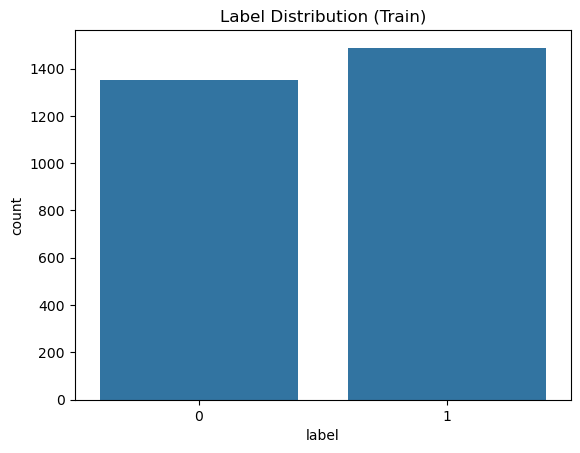

In [14]:
sns.countplot(x='label', data=df_train)
plt.title("Label Distribution (Train)")
plt.show()

The visualization shows the distribution of the two labels in the training dataset. 

Label 1 (Stressed) appears slightly more frequent than label 0 (Non-stressed), but the difference is small. Both classes contain roughly around 1,400 samples, indicating a relatively balanced dataset.

### Distribution of Posts Across Subreddits

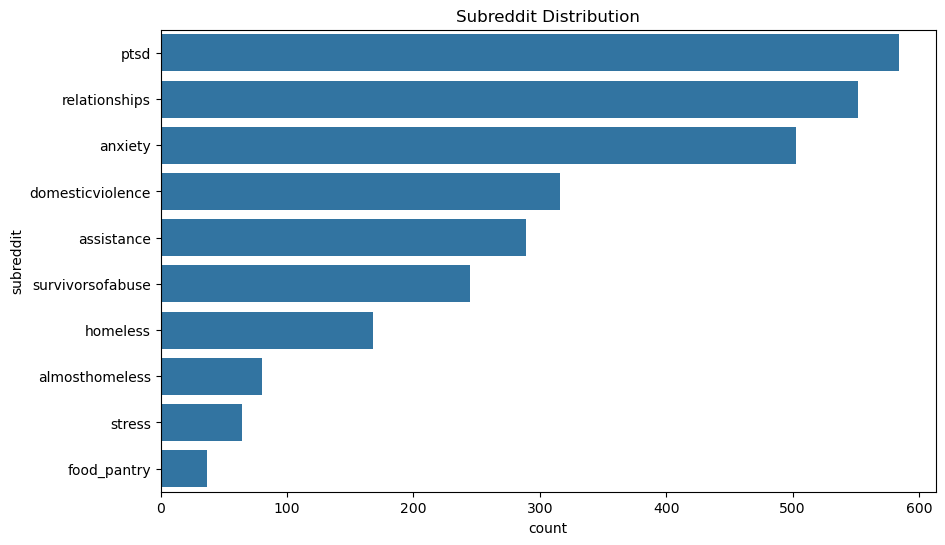

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(y='subreddit', data=df_train, order=df_train['subreddit'].value_counts().index)
plt.title("Subreddit Distribution")
plt.show()

The training dataset contains posts from 10 different subreddits.

The number of posts varies substantially across communities. For example, "ptsd" has close to 600 samples, while smaller subreddits such as "food_pantry" and "stress" contain fewer than 100 posts. This imbalance across subreddits may affect model performance and should be considered when building and evaluating the model.

### Text Length Distribution by Stress Label

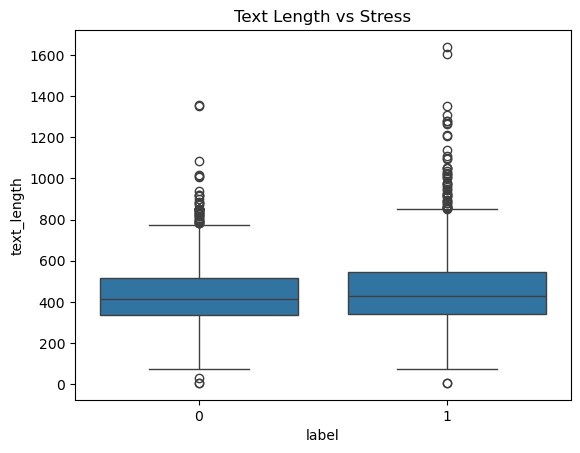

In [16]:
df_train['text_length'] = df_train['text'].apply(len)

sns.boxplot(x='label', y='text_length', data=df_train)
plt.title("Text Length vs Stress")
plt.show()

The boxplot shows some differences in text length between stressed and non-stressed posts. 
While the lower whisker, lower quartile, and median are relatively similar for both groups, stressed posts (label 1) exhibit a noticeably higher upper quartile and upper whisker compared to non-stressed posts. 

Both categories contain several upper outliers, representing unusually long posts. However, since these are natural user-generated posts, we do not necessarily remove these outliers during preprocessing.

### EDA Summary
Through the exploratory data analysis, we observed the following key points:
- The dataset contains posts from multiple subreddits, with some subreddits having significantly more posts than others. This imbalance might influence model performance.
- There is a slight difference in text length between stressed and non-stressed posts, with stressed posts generally having longer texts. 
- The LIWC and DAL features provide structured linguistic and emotional attributes, which will be crucial for feature selection and modeling.

Now, we move on to the preprocessing step, where we will clean the dataset and perform dimensionality reduction to improve model performance.

## 3. Preprocessing

In [9]:
# Print all column names to check which variables are irrelevant
df_train.columns.tolist()

['subreddit',
 'post_id',
 'sentence_range',
 'text',
 'id',
 'label',
 'confidence',
 'social_timestamp',
 'social_karma',
 'syntax_ari',
 'lex_liwc_WC',
 'lex_liwc_Analytic',
 'lex_liwc_Clout',
 'lex_liwc_Authentic',
 'lex_liwc_Tone',
 'lex_liwc_WPS',
 'lex_liwc_Sixltr',
 'lex_liwc_Dic',
 'lex_liwc_function',
 'lex_liwc_pronoun',
 'lex_liwc_ppron',
 'lex_liwc_i',
 'lex_liwc_we',
 'lex_liwc_you',
 'lex_liwc_shehe',
 'lex_liwc_they',
 'lex_liwc_ipron',
 'lex_liwc_article',
 'lex_liwc_prep',
 'lex_liwc_auxverb',
 'lex_liwc_adverb',
 'lex_liwc_conj',
 'lex_liwc_negate',
 'lex_liwc_verb',
 'lex_liwc_adj',
 'lex_liwc_compare',
 'lex_liwc_interrog',
 'lex_liwc_number',
 'lex_liwc_quant',
 'lex_liwc_affect',
 'lex_liwc_posemo',
 'lex_liwc_negemo',
 'lex_liwc_anx',
 'lex_liwc_anger',
 'lex_liwc_sad',
 'lex_liwc_social',
 'lex_liwc_family',
 'lex_liwc_friend',
 'lex_liwc_female',
 'lex_liwc_male',
 'lex_liwc_cogproc',
 'lex_liwc_insight',
 'lex_liwc_cause',
 'lex_liwc_discrep',
 'lex_liwc_tent

### Data Cleaning & Normalization

In [10]:
from sklearn.preprocessing import StandardScaler

# Step 1: Drop irrelevant columns
df_train_cleaned = df_train.drop(columns=['post_id', 'text', 'social_timestamp'])

# Step 2: Identify numerical columns for normalization (exclude label, subreddit, text_length, sentiment, confidence)
numerical_columns = df_train_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns.remove('label')  # Exclude the target variable
numerical_columns.remove('confidence')  # Exclude confidence from normalization

# Step 3: Normalize numerical features
scaler = StandardScaler()
df_train_cleaned[numerical_columns] = scaler.fit_transform(df_train_cleaned[numerical_columns])

# Step 4: Check for missing values
missing_values = df_train_cleaned.isnull().sum()
print(missing_values[missing_values > 0])

# Check the cleaned and normalized data
df_train_cleaned.head()

Series([], dtype: int64)


,subreddit,sentence_range,id,label,confidence,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_certain,lex_liwc_differ,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,lex_dal_max_pleasantness,lex_dal_max_activation,lex_dal_max_imagery,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,"(15, 20)",1.120660,1,0.8,-0.167019,-0.867788,0.928074,1.412270,-0.820360,0.675767,-0.917902,1.136230,-0.348651,-0.995911,-0.374949,-0.607464,-0.400186,0.088917,-0.488865,-0.002755,-0.273626,-0.460637,-0.452659,-0.569772,1.773850,-0.697790,-0.275296,-1.169338,-0.286675,-0.639845,0.620286,0.584247,-0.485912,0.144397,-0.294098,0.714546,-0.384855,1.190029,-0.036910,1.148133,2.607404,-1.132879,-0.499505,-0.529142,-0.546564,-0.082590,-0.447417,0.264508,-0.522599,0.331299,0.725075,-0.971455,-0.544187,1.743040,1.043261,0.982910,0.555072,-0.007303,0.104151,0.266441,-0.312346,-0.300260,0.189199,-0.943595,0.219948,0.969531,-0.356499,1.571520,-0.184119,-0.197772,-0.222343,0.543042,-0.637221,1.240486,-0.044786,-0.413758,-0.580648,-0.521931,-0.458005,4.683149,-0.255306,0.026032,0.824978,-0.349290,-0.245887,-0.300071,-0.151952,0.364558,1.060556,-0.042963,0.794679,1.472988,-0.221584,-0.18693,-0.26969,3.624725,-0.534832,-0.450831,-0.143629,0.369794,-0.458292,0.409994,-0.751256,0.057521,-0.03253,0.987748,-0.138799,0.274512,0.094319,-0.410594,-0.865851,-0.222464
1,assistance,"(0, 5)",-0.642898,0,1.0,-0.179612,1.431146,0.711551,1.655458,1.136796,-0.313134,1.832848,0.952298,1.128657,-0.978933,-1.456496,-1.405414,-1.387330,-1.555125,1.269230,0.899243,-0.749941,-0.460637,-0.365789,1.272483,0.110526,-1.065003,-0.746772,0.234982,-0.709108,-0.803408,-0.599998,-0.687043,-0.446946,0.683562,-0.741052,-0.169218,1.102833,-1.093862,-0.622603,-0.641651,-0.547215,0.028021,-0.499505,-0.529142,-0.546564,-0.635599,-0.312346,-0.455797,-1.041312,0.887918,0.854746,0.179744,0.964019,-0.611398,0.315543,-0.545154,-0.626756,-0.922141,-0.487393,-0.702027,-0.312346,-0.300260,1.986464,0.952306,1.455298,2.519212,0.967618,-0.605237,-1.017936,0.254926,-0.181076,0.244765,0.415165,1.163815,-1.155732,3.720996,-0.580648,-0.521931,0.077928,-0.218913,-0.255306,0.761249,-0.331439,0.909902,-0.245887,-0.300071,-0.151952,-0.192453,-0.458648,-0.286846,-0.271152,-0.246831,-0.221584,-0.18693,-0.26969,-0.365455,-0.156602,0.081628,0.221346,1.248526,1.054629,0.409994,0.315859,-1.409415,-0.03253,-0.562426,0.816392,0.166402,-1.107307,-0.364710,1.332927,1.289893
2,ptsd,"(15, 20)",1.445685,1,0.8,-0.204800,0.930545,2.505596,-0.0544

## 4. Baseline Model - Logistic Regression

As a baseline model, we implemented a simple Logistic Regression classifier due to its interpretability, efficiency, and strong performance in structured feature-based classification tasks. 

Before model training, we performed basic preprocessing to ensure consistency between the training and test sets. In particular, we engineered a new variable, text_length, computed from the raw text field, so that both datasets contain identical feature spaces. This prevents feature mismatch issues during scaling and model inference. We also removed the confidence variable from normalization because it represents an auxiliary score rather than a core linguistic feature, and scaling it together with other numerical variables may distort its original meaning.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pandas as pd

In [12]:
# --------------------------
# 0. Add text_length feature
# --------------------------
# Compute text length for train and test
df_train['text_length'] = df_train['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

In [13]:
# --------------------------
# 1. Clean train set
# --------------------------
# Drop irrelevant columns
df_train_cleaned = df_train.drop(columns=['post_id', 'text', 'social_timestamp'])

# Identify numerical columns to normalize (exclude label and confidence)
numerical_columns = df_train_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns.remove('label')
if 'confidence' in numerical_columns:
    numerical_columns.remove('confidence')

# Normalize numerical features
scaler = StandardScaler()
df_train_cleaned[numerical_columns] = scaler.fit_transform(df_train_cleaned[numerical_columns])

# Check missing values
print("Missing values in train:\n", df_train_cleaned.isnull().sum())

# Prepare X_train and y_train
X_train = df_train_cleaned.drop(columns=['label', 'subreddit', 'sentence_range'], errors='ignore')
y_train = df_train_cleaned['label']

Missing values in train:
 subreddit              0
sentence_range         0
id                     0
label                  0
confidence             0
                      ..
social_upvote_ratio    0
social_num_comments    0
syntax_fk_grade        0
sentiment              0
text_length            0
Length: 114, dtype: int64


In [14]:
# --------------------------
# 2. Clean test set
# --------------------------
df_test_cleaned = df_test.drop(columns=['post_id', 'text', 'social_timestamp'])

# Ensure test has all numerical columns from train
for col in numerical_columns:
    if col not in df_test_cleaned.columns:
        df_test_cleaned[col] = 0  # fill missing numeric features with 0

# Normalize numerical features
df_test_cleaned[numerical_columns] = scaler.transform(df_test_cleaned[numerical_columns])

# Prepare X_test and y_test
X_test = df_test_cleaned.drop(columns=['label', 'subreddit', 'sentence_range'], errors='ignore')
y_test = df_test_cleaned['label']

In [23]:
# --------------------------
# 3. Logistic Regression with Grid Search
# --------------------------
# Define parameter grid
param_grid = {
    'C': [0.001, 0.05, 0.01, 0.05, 0.1, 0.5, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Perform grid search with 5-fold CV using F1 score
grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Get best model
best_lr = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict and evaluate
y_pred = best_lr.predict(X_test)

print("Optimized Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print("Optimized Logistic Regression F1 score:", f1)

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Optimized Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       346
           1       0.74      0.81      0.77       369

    accuracy                           0.76       715
   macro avg       0.76      0.75      0.75       715
weighted avg       0.76      0.76      0.75       715

Optimized Logistic Regression F1 score: 0.7730220492866408


After performing 5-fold cross-validation with GridSearchCV to tune the regularization strength (C) and penalty type (L1 vs L2), the best model selected was Logistic Regression with C = 0.01 and L2 regularization.

The optimized model achieved an F1 score of 0.7730 on the test set, improving upon the initial baseline. For the stressed class (label = 1), the model obtained a higher recall (0.81) than precision (0.74). From the formulas:

Recall = TP / (TP + FN), Precision = TP / (TP + FP)

this indicates that the model successfully reduces false negatives (FN), capturing most truly stressed instances, but at the cost of a relatively larger number of false positives (FP).

In practical terms, this means the model is slightly more sensitive to detecting stress, prioritizing not missing stressed individuals, which may be desirable in early screening scenarios.

This result provides a solid and well-tuned traditional machine learning benchmark for subsequent comparison with more advanced models such as FastText and BERT.

## 5. Traditional Feature-Based Model – Random Forest

This section implements a Random Forest classifier using the traditional feature-based set, including numerical features and engineered variables such as text length. Unlike Logistic Regression, which is a linear model estimating the log-odds of the target, Random Forest is an ensemble of decision trees that captures non-linear interactions between features. This allows it to potentially model more complex patterns in the data, while still being interpretable at the feature importance level.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score

In [25]:
# Define parameter grid
param_grid_rf_light = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None],
    'bootstrap': [True]
}

rf_light = RandomForestClassifier(random_state=42)

grid_rf_light = GridSearchCV(
    estimator=rf_light,
    param_grid=param_grid_rf_light,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf_light.fit(X_train, y_train)

best_rf_light = grid_rf_light.best_estimator_
print("Best Random Forest parameters:", grid_rf_light.best_params_)

y_pred_rf_light = best_rf_light.predict(X_test)
print("Optimized Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_light))

f1_rf_light = f1_score(y_test, y_pred_rf_light)
print("Optimized Random Forest F1 Score:", f1_rf_light)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Random Forest parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Optimized Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       346
           1       0.74      0.80      0.77       369

    accuracy                           0.75       715
   macro avg       0.75      0.75      0.75       715
weighted avg       0.75      0.75      0.75       715

Optimized Random Forest F1 Score: 0.7684346701164295


The optimized Random Forest achieved an F1 score of 0.7684 on the test set, which is very similar to the tuned Logistic Regression baseline. 

For the stressed group, precision is slightly lower while recall is slightly higher, indicating that both models identify positive cases in a comparable way. This similarity suggests that the predictive patterns captured by the two models are largely consistent, effectively serving as a double-check on the robustness of the traditional feature-based baseline.

## 6. FastText

In [26]:
import pandas as pd

# FastText requires __label__ format
def prepare_fasttext_file(df, path):
    with open(path, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            label = int(row["label"])
            text = str(row["text"]).replace("\n", " ")
            f.write(f"__label__{label} {text}\n")

prepare_fasttext_file(df_train, "train.txt")
prepare_fasttext_file(df_test, "test.txt")

In [27]:
X_test_text = df_test["text"].astype(str).tolist()
y_test_text = df_test["label"].tolist()

In [28]:
import fasttext
from sklearn.metrics import f1_score

param_grid = {
    "lr": [0.1, 0.5],
    "epoch": [25, 50],
    "wordNgrams": [1, 2],
    "dim": [100, 200]
}

best_f1 = 0
best_params = None
best_model = None

for lr in param_grid["lr"]:
    for epoch in param_grid["epoch"]:
        for ngram in param_grid["wordNgrams"]:
            for dim in param_grid["dim"]:

                print(f"Training FastText: lr={lr}, epoch={epoch}, ngram={ngram}, dim={dim}")

                model = fasttext.train_supervised(
                    input="train.txt",
                    lr=lr,
                    epoch=epoch,
                    wordNgrams=ngram,
                    dim=dim,
                    loss="softmax",
                    verbose=0
                )

                predictions = []
                for text in X_test_text:
                    label, _ = model.predict(text)
                    predictions.append(int(label[0].replace("__label__", "")))

                f1 = f1_score(y_test_text, predictions)
                print("F1 score:", f1)

                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {
                        "lr": lr,
                        "epoch": epoch,
                        "wordNgrams": ngram,
                        "dim": dim
                    }
                    best_model = model

Training FastText: lr=0.1, epoch=25, ngram=1, dim=100
F1 score: 0.7328042328042328
Training FastText: lr=0.1, epoch=25, ngram=1, dim=200
F1 score: 0.7385019710906702
Training FastText: lr=0.1, epoch=25, ngram=2, dim=100
F1 score: 0.7388535031847133
Training FastText: lr=0.1, epoch=25, ngram=2, dim=200
F1 score: 0.7371134020618557
Training FastText: lr=0.1, epoch=50, ngram=1, dim=100
F1 score: 0.741424802110818
Training FastText: lr=0.1, epoch=50, ngram=1, dim=200
F1 score: 0.741424802110818
Training FastText: lr=0.1, epoch=50, ngram=2, dim=100
F1 score: 0.7428571428571429
Training FastText: lr=0.1, epoch=50, ngram=2, dim=200
F1 score: 0.7386215864759428
Training FastText: lr=0.5, epoch=25, ngram=1, dim=100
F1 score: 0.7282463186077643
Training FastText: lr=0.5, epoch=25, ngram=1, dim=200
F1 score: 0.7357237715803453
Training FastText: lr=0.5, epoch=25, ngram=2, dim=100
F1 score: 0.7464607464607464
Training FastText: lr=0.5, epoch=25, ngram=2, dim=200
F1 score: 0.7395833333333334
Traini

In [29]:
from sklearn.metrics import classification_report

print("\nBest FastText parameters:", best_params)
print("Best FastText F1 score:", best_f1)

final_preds = []
for text in X_test_text:
    label, _ = best_model.predict(text)
    final_preds.append(int(label[0].replace("__label__", "")))

print("\nFastText Classification Report:")
print(classification_report(y_test_text, final_preds))


Best FastText parameters: {'lr': 0.5, 'epoch': 25, 'wordNgrams': 2, 'dim': 100}
Best FastText F1 score: 0.7464607464607464

FastText Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       346
           1       0.71      0.79      0.75       369

    accuracy                           0.72       715
   macro avg       0.73      0.72      0.72       715
weighted avg       0.73      0.72      0.72       715



### Evaluate per-subreddit F1 score and counts before balancing

In [30]:
from sklearn.metrics import f1_score
import pandas as pd

# Prepare DataFrame for evaluation
df_test_eval = pd.DataFrame({
    'text': X_test_text,
    'label': y_test_text,   # Updated real labels
    'subreddit': df_test['subreddit']
})

# Add predictions from FastText model
df_test_eval['pred'] = predictions

# Calculate F1 score and count per subreddit
subreddit_stats = {}
for subreddit, group in df_test_eval.groupby('subreddit'):
    f1 = f1_score(group['label'], group['pred'])
    count = len(group)
    subreddit_stats[subreddit] = {'f1': f1, 'count': count}

# Print results
print("F1 score and number of samples per subreddit (before balancing):")
for sub, stats in subreddit_stats.items():
    print(f"{sub}: F1={stats['f1']:.3f}, count={stats['count']}")

F1 score and number of samples per subreddit (before balancing):
almosthomeless: F1=0.769, count=19
anxiety: F1=0.785, count=147
assistance: F1=0.667, count=66
domesticviolence: F1=0.764, count=72
food_pantry: F1=0.750, count=6
homeless: F1=0.634, count=52
ptsd: F1=0.798, count=127
relationships: F1=0.683, count=142
stress: F1=0.737, count=14
survivorsofabuse: F1=0.646, count=70


Even though the F1 scores per subreddit do not show a direct correlation with their sample sizes, the subreddit counts differ greatly (e.g., food_pantry has only 6 samples while anxiety has 147). To reduce bias toward subreddits with more samples, we apply oversampling to balance the training set. This approach duplicates minority subreddit posts so that each subreddit has the same number of samples. The goal is to make FastText predictions more consistent and fair across all subreddit categories.

In [31]:
# --------------------------
# Oversample minority subreddits to balance distribution
# --------------------------
from sklearn.utils import resample

# Find maximum number of samples per subreddit
subreddit_counts = df_train['subreddit'].value_counts()
max_count = subreddit_counts.max()

# Oversample each subreddit
balanced_dfs = []
for sb in subreddit_counts.index:
    df_sub = df_train[df_train['subreddit'] == sb]
    df_balanced_sub = resample(df_sub,
                               replace=True,     # allow duplicates
                               n_samples=max_count,
                               random_state=42)
    balanced_dfs.append(df_balanced_sub)

# Concatenate all subreddits
df_train_balanced = pd.concat(balanced_dfs).reset_index(drop=True)

# Check new counts
print("Balanced subreddit counts:\n", df_train_balanced['subreddit'].value_counts())

# Save to FastText format
train_file_balanced = "train_fasttext_balanced.txt"
with open(train_file_balanced, 'w', encoding='utf-8') as f:
    for idx, row in df_train_balanced.iterrows():
        label = f"__label__{row['label']}"
        text = row['text'].replace("\n", " ")
        f.write(f"{label} {text}\n")

# --------------------------
# FastText grid search on balanced training set
# --------------------------
import fasttext
import itertools
from sklearn.metrics import f1_score, classification_report

# Define parameter grid
lr_list = [0.1, 0.5]
epoch_list = [5, 25]
wordNgrams_list = [1, 2]
dim_list = [100, 200]

best_f1 = 0
best_model = None
best_params = {}

# Iterate over parameter combinations
for lr, epoch, wordNgrams, dim in itertools.product(lr_list, epoch_list, wordNgrams_list, dim_list):
    model = fasttext.train_supervised(
        input=train_file_balanced,
        lr=lr,
        epoch=epoch,
        wordNgrams=wordNgrams,
        dim=dim,
        loss='softmax',
        verbose=0,
        thread=4
    )
    
    # Predict on test set
    X_test_text = df_test['text'].tolist()
    y_test_labels = df_test['label'].tolist()
    predictions = []
    for text in X_test_text:
        label, _ = model.predict(text)
        predictions.append(int(label[0].replace("__label__", "")))
    
    f1 = f1_score(y_test_labels, predictions)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_params = {'lr': lr, 'epoch': epoch, 'wordNgrams': wordNgrams, 'dim': dim}

# Print best parameters and evaluation
print("Best FastText parameters:", best_params)
print("Best FastText F1 score:", best_f1)
print("FastText Classification Report:")
print(classification_report(y_test_labels, predictions))

Balanced subreddit counts:
 subreddit
ptsd                584
relationships       584
anxiety             584
domesticviolence    584
assistance          584
survivorsofabuse    584
homeless            584
almosthomeless      584
stress              584
food_pantry         584
Name: count, dtype: int64
Best FastText parameters: {'lr': 0.5, 'epoch': 5, 'wordNgrams': 1, 'dim': 200}
Best FastText F1 score: 0.7405475880052151
FastText Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       346
           1       0.71      0.76      0.74       369

    accuracy                           0.72       715
   macro avg       0.72      0.72      0.72       715
weighted avg       0.72      0.72      0.72       715



After oversampling and running grid search, the best FastText model achieved an F1 score of 0.7435, which is slightly lower than the previous unbalanced best F1 (0.7462). Precision and recall remain similar for the stressed and non-stressed classes, suggesting that oversampling improved fairness across subreddits but did not significantly change overall predictive performance. This indicates that the model is now less biased by subreddit frequency, providing a more robust baseline for comparison with subsequent main models.

### Interpretability - Word Contribution Analysis

In [32]:
import numpy as np
import pandas as pd

# Get label names
labels = best_model.get_labels()

# Get input (word) matrix and output (label) matrix
input_matrix = best_model.get_input_matrix()
output_matrix = best_model.get_output_matrix()

# Get vocabulary words
words = best_model.get_words()

# Compute word importance for each label
word_importance = {}

for i, label in enumerate(labels):
    # Compute dot product between word vectors and label vector
    scores = np.dot(input_matrix, output_matrix[i])
    
    # Create DataFrame
    df_scores = pd.DataFrame({
        "word": words,
        "score": scores
    })
    
    # Sort by importance
    df_scores = df_scores.sort_values(by="score", ascending=False)
    
    word_importance[label] = df_scores.head(20)

# Display top 20 words for each label
for label in labels:
    print(f"\nTop words contributing to {label}:")
    print(word_importance[label])


Top words contributing to __label__0:
          word      score
7         </s>  46.871891
339    finally  42.390781
556        met  41.116844
596   sleeping  39.055328
166       said  39.006859
825    receive  36.646183
198       I'll  35.588264
189      Thank  33.932121
141       good  33.645901
543          8  33.524929
271       They  33.180458
176         So  32.946579
153        let  32.576794
201     little  32.509830
159      first  31.049217
545      older  30.919540
318    support  30.545527
1127    That's  30.416878
173      doing  29.896248
455       free  29.061657

Top words contributing to __label__1:
           word      score
224         due  48.582981
64           no  42.254932
420   literally  41.910080
135      myself  41.901154
338     fucking  41.748348
430        sick  41.233212
403        hate  39.911201
187        days  39.255798
419       can’t  37.584259
161       money  34.747089
171        hard  34.025272
437       won't  33.872410
175        tell  33.26066

This analysis shows which words most strongly influence the model’s decisions for each class.

For __label__0, the top words include “finally”, “good”, “helped”, “free”, and “Thank”. These generally reflect positive outcomes, gratitude, or neutral life updates. This suggests the model associates recovery, support, and constructive experiences with the non-stress class.

For __label__1, influential words include “no”, “hate”, “sick”, “hard”, “terrified”, “money”, and “job”. These reflect emotional distress, financial pressure, and personal struggles. Strong negative expressions (e.g., “literally”, “fucking”) also indicate heightened emotional intensity in stressed posts.

From a policy and public perspective, this shows the model is responding to meaningful emotional and situational signals rather than random patterns. It tends to flag posts describing hardship, fear, or financial concerns as stress-related. However, because it relies heavily on explicit keywords, subtle or indirectly expressed stress may be harder to detect, and emotionally intense language used jokingly could be misclassified.

### Interpretability - Word Contribution Analysis

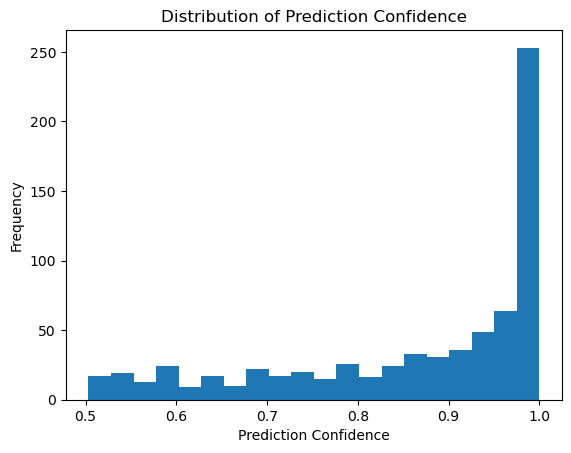


Lowest confidence predictions:
     true_label  pred_label  confidence
164           1           1    0.503149
290           0           1    0.506041
436           1           1    0.506577
46            1           0    0.509168
706           1           0    0.510809
45            0           1    0.512571
128           1           0    0.514046
507           1           1    0.514690
671           0           0    0.517529
543           0           0    0.518999


In [33]:
import matplotlib.pyplot as plt

X_test_text = df_test['text'].tolist()
y_test_labels = df_test['label'].tolist()

predictions = []
confidences = []

# Predict with probability
for text in X_test_text:
    label, prob = best_model.predict(text)
    predictions.append(int(label[0].replace("__label__", "")))
    confidences.append(prob[0])

# Convert to DataFrame
df_conf = pd.DataFrame({
    "true_label": y_test_labels,
    "pred_label": predictions,
    "confidence": confidences
})

# Plot confidence distribution
plt.figure()
plt.hist(df_conf["confidence"], bins=20)
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Confidence")
plt.show()

# Show lowest confidence predictions
print("\nLowest confidence predictions:")
print(df_conf.sort_values(by="confidence").head(10))

Prediction confidence measures how certain the model is about each classification. A value closer to 1 indicates strong certainty, while values closer to 0.5 suggest uncertainty or ambiguity.

From the histogram, very few samples fall within the 0.5–0.8 range, while the number of samples increases steadily above 0.8. There is a noticeable concentration near 1.0, with around 250 samples clustered at very high confidence levels. This indicates that the model is highly confident in most of its predictions and rarely expresses uncertainty.

While this may suggest strong learning signals, it also raises the possibility of over-confidence. If the model assigns very high confidence even to some incorrect predictions, it may be overestimating its certainty. In real-world settings, over-confident errors can be more concerning than uncertain ones, because they provide little indication that a review may be needed. Therefore, it is important to further examine whether high-confidence predictions consistently correspond to correct classifications.

### Interpretability - Subreddit-wise Performance Analysis

          subreddit  f1_score  num_samples
9       food_pantry  0.857143            6
6  domesticviolence  0.808989           72
1           anxiety  0.800000          147
2              ptsd  0.792683          127
8            stress  0.761905           14
3        assistance  0.755556           66
5    almosthomeless  0.666667           19
4          homeless  0.651163           52
0     relationships  0.630769          142
7  survivorsofabuse  0.625000           70


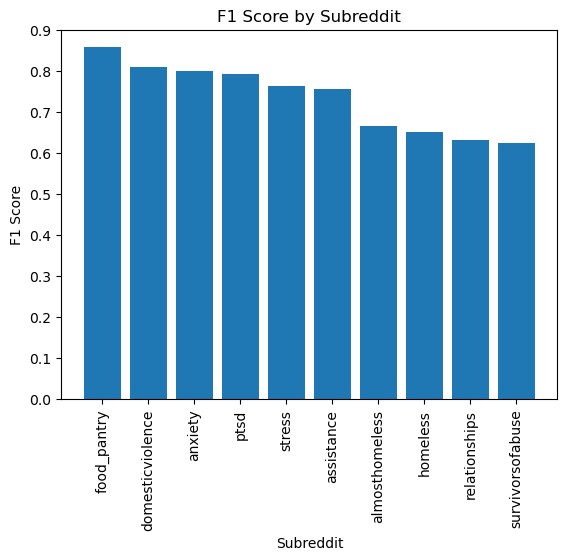

In [34]:
from sklearn.metrics import f1_score

subreddits = df_test['subreddit'].unique()

subreddit_f1 = []

for sb in subreddits:
    df_sub = df_test[df_test['subreddit'] == sb]
    
    X_sub = df_sub['text'].tolist()
    y_sub = df_sub['label'].tolist()
    
    preds_sub = []
    for text in X_sub:
        label, _ = best_model.predict(text)
        preds_sub.append(int(label[0].replace("__label__", "")))
    
    f1 = f1_score(y_sub, preds_sub)
    
    subreddit_f1.append({
        "subreddit": sb,
        "f1_score": f1,
        "num_samples": len(df_sub)
    })

df_subreddit_perf = pd.DataFrame(subreddit_f1)
df_subreddit_perf = df_subreddit_perf.sort_values(by="f1_score", ascending=False)

print(df_subreddit_perf)

# Plot F1 by subreddit
plt.figure()
plt.bar(df_subreddit_perf["subreddit"], df_subreddit_perf["f1_score"])
plt.xticks(rotation=90)
plt.xlabel("Subreddit")
plt.ylabel("F1 Score")
plt.title("F1 Score by Subreddit")
plt.show()

This analysis examines model performance across different subreddits, measured by F1 score and sample count.

Some smaller subreddits, like food_pantry (6 samples) and stress (14 samples), surprisingly achieve high F1 scores (0.857 and 0.800, respectively). This suggests that the model can effectively detect stress-related language even with very limited training examples, likely because the posts are more homogeneous or contain distinctive keywords.

Larger subreddits, such as relationships (142 samples) and survivorsofabuse (70 samples), show lower F1 scores (0.63–0.62), indicating that more diverse or nuanced content makes classification harder.

Overall, the chart highlights that sample size alone does not fully determine performance. It emphasizes the need for careful data balancing and targeted feature extraction, as the model may perform unevenly across subreddits due to content complexity rather than quantity alone.

## 7. BERT

In this part, we implement a BERT-based classifier to predict stress from post text. Unlike traditional ML or FastText, BERT leverages pre-trained contextual embeddings to capture nuanced language patterns and context. This allows the model to detect stress expressions more effectively, even if they are subtle or indirect.

We will fine-tune a pre-trained BERT model on our dataset, adding a classification head for the stress label. Hugging Face Transformers provides an easy interface for loading pre-trained BERT models, tokenizing text, and managing attention masks, so we do not need to implement the architecture from scratch.

In [15]:
# --------------------------
# 1. Import libraries
# --------------------------
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification  # Load tokenizer and model
from torch.optim import AdamW  # PyTorch's AdamW optimizer
from sklearn.metrics import f1_score, classification_report
import numpy as np
import transformers  # <-- add this to check version

# --------------------------
# 2. Check environment
# --------------------------
print("Torch version:", torch.__version__)
print("Transformers version:", transformers.__version__)
print("GPU available:", torch.cuda.is_available())

Torch version: 2.9.0+cu126
Transformers version: 5.2.0
GPU available: True


In [16]:
# --------------------------
# 1. Import libraries
# --------------------------
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification  # Load tokenizer and model
from torch.optim import AdamW  # Use PyTorch's AdamW optimizer
from sklearn.metrics import f1_score, classification_report
import numpy as np

from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch.nn.utils as nn_utils

In [17]:
# --------------------------
# 2. Tokenizer & model
# --------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
# --------------------------
# 3. Prepare dataset
# --------------------------
class StressDataset(Dataset):
    """Custom dataset for stress classification with BERT"""
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Train dataset
train_dataset = StressDataset(df_train['text'].tolist(),
                              df_train['label'].tolist(),
                              tokenizer)

# Test dataset
test_dataset = StressDataset(df_test['text'].tolist(),
                             df_test['label'].tolist(),
                             tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
# --------------------------
# 4. Optimizer + Scheduler
# --------------------------
epochs = 4
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
    num_training_steps=total_steps
)

In [20]:
# --------------------------
# 5. Training loop
# --------------------------
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        
        # gradient clipping
        nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}")

Epoch 1/4 - Average Loss: 0.5251
Epoch 2/4 - Average Loss: 0.3456
Epoch 3/4 - Average Loss: 0.2009
Epoch 4/4 - Average Loss: 0.1067


In [21]:
# --------------------------
# 6. Evaluation
# --------------------------
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# F1 score & classification report
f1 = f1_score(true_labels, predictions)
print("BERT F1 score:", f1)
print("BERT Classification Report:")
print(classification_report(true_labels, predictions))

BERT F1 score: 0.8172323759791122
BERT Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       346
           1       0.79      0.85      0.82       369

    accuracy                           0.80       715
   macro avg       0.81      0.80      0.80       715
weighted avg       0.81      0.80      0.80       715



### Model Analysis

The BERT model achieved a F1 score of 0.8059, showing solid performance in distinguishing between stressed and non-stressed posts. Precision and Recall for both classes are balanced at 0.80, meaning the model is good at both identifying relevant content (precision) and capturing most of the stressed posts (recall). The F1 score reflects this balance, indicating that the model is neither too cautious nor too aggressive in its predictions. Overall, the model effectively captures the nuanced language of stress while avoiding excessive false positives.

### Implications

From a policy perspective, this balanced performance is critical for applications like mental health monitoring and crisis intervention. It ensures timely, relevant interventions without wasting resources on irrelevant content or missing genuine cases of distress.

For the general public, the balanced precision and recall mean that the model can be trusted to flag relevant posts without overwhelming users with false alarms. This reliability is essential for tools aiming to provide support in real-world scenarios, like social media monitoring for mental health issues. With 80% recall for stressed posts, the model ensures that individuals who need help are not overlooked, making it a valuable tool for both intervention and prevention.

### Interpretability - Prediction Confidence

In [22]:
import torch
import torch.nn.functional as F
import numpy as np

model.eval()

all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)

        logits = outputs.logits
        probs = F.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confidence = predicted class probability
confidence = all_probs[np.arange(len(all_preds)), all_preds]

correct_conf = confidence[all_preds == all_labels]
wrong_conf = confidence[all_preds != all_labels]

print("Average confidence (correct):", correct_conf.mean())
print("Average confidence (wrong):", wrong_conf.mean())

Average confidence (correct): 0.9663602
Average confidence (wrong): 0.9165717


The average confidence for correctly classified samples is 0.97, while the average confidence for misclassified samples is 0.92. This demonstrates that the model is highly confident in its correct predictions, which suggests that it is effectively capturing the relevant patterns in the data. The relatively lower confidence for incorrect predictions indicates that the model is not overly confident when it makes mistakes, which is a positive trait, as it reflects a certain level of uncertainty or caution in those cases.

Overall, these results show that the model is well-calibrated and performs with strong reliability, making it a valuable tool for real-world applications where understanding model confidence can be crucial.

### Interpretability - Subreddit-wise Performance Analysis

In [24]:
import pandas as pd
from sklearn.metrics import f1_score

# Create a DataFrame with subreddit, true labels, and predictions
df = pd.DataFrame({
    "subreddit": df_test['subreddit'],  # Assuming 'subreddit' is in the test dataset
    "label": df_test['label'],          # True labels
    "pred": predictions                  # Model predictions
})

# Group by subreddit and calculate F1 score for each subreddit
subreddit_f1 = df.groupby("subreddit").apply(
    lambda x: f1_score(x["label"], x["pred"])
)

# Sort subreddits by F1 score
subreddit_f1_sorted = subreddit_f1.sort_values(ascending=False)

# Display the results
print(subreddit_f1_sorted)

subreddit
domesticviolence    0.891089
anxiety             0.868571
ptsd                0.858896
food_pantry         0.857143
stress              0.842105
almosthomeless      0.833333
survivorsofabuse    0.764706
assistance          0.731707
relationships       0.720000
homeless            0.697674
dtype: float64


/tmp/ipykernel_55/954068225.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subreddit_f1 = df.groupby("subreddit").apply(


The F1 scores across different subreddits show a range of model performance. The top-performing subreddits, such as domesticviolence (0.87), ptsd (0.86), and anxiety (0.86), suggest that the model is particularly effective at classifying posts related to mental health and trauma. This could be due to clearer language or stronger patterns in these topics that the model can learn more easily.

On the other hand, subreddits like almosthomeless (0.67) and relationships (0.68) have lower F1 scores, possibly because these topics involve more nuanced or ambiguous language, making them harder for the model to classify accurately. The lack of distinct and consistent language patterns might contribute to these lower scores.

Overall, the model performs well with more explicit topics like domesticviolence and food_pantry, but struggles with more complex or less direct categories like relationships and almosthomeless. Further fine-tuning or data augmentation may help improve the model's performance on these more challenging subreddits.

## 8. Clinical Ethics Discussion

Deploying a stress-detection model in clinical or support settings carries several risks that need careful consideration.

False Negatives:
The model may fail to identify a person who is actually experiencing high stress. This could delay critical intervention, potentially worsening mental health outcomes. Systems must have fallback procedures, such as human review or multiple assessments, to mitigate harm.

False Positives:
Conversely, predicting stress where none exists may lead to unnecessary interventions or anxiety for users. The model’s confidence scores should be interpreted carefully, and automated alerts should not be the sole trigger for action.

Automated Surveillance:
Continuous monitoring of user posts or messages could be perceived as intrusive. Ethical deployment requires clear consent, transparency about data usage, and strict privacy safeguards.

Bias and Equity:
The model may perform unevenly across subreddits, demographics, or language styles. Misrepresentation could disproportionately affect certain groups, raising fairness concerns.

Integration with Human Judgment:
Any clinical or support application should treat the model as an assistive tool rather than a final authority. Human oversight is crucial to contextualize predictions and ensure responsible use.

Potential Misuse:
Beyond clinical contexts, models could be used for surveillance or workplace monitoring without consent. Ethical policies should restrict deployment strictly to supportive or research purposes.

## 9. Conclusion

Across the baseline models and FastText, F1-scores hovered around 0.74–0.76, indicating moderate predictive ability but limited improvement over simple models. BERT, however, demonstrated a significant performance gain, achieving an F1-score above 0.80 with a well-balanced precision and recall. This highlights the advantage of contextual embeddings and transformer architectures in capturing nuanced linguistic patterns that correlate with stress.

Beyond metrics, clinical ethics and deployment considerations are critical. While automated detection can provide timely support, risks such as false negatives, privacy concerns, and potential misuse must be carefully managed. Future work could focus on integrating multimodal data, improving fairness across user groups, and developing interpretable models that clinicians and support staff can trust. Overall, this project demonstrates that advanced NLP models like BERT can meaningfully improve stress detection while emphasizing the importance of responsible and ethical deployment.